## Análisis de datos fallecidos Covid-19 en Colombia

Para la fecha del presente, Colombia es uno de los países más afectados por la pandemia del Coronavirus, contando con más de 6 millones de contagios a pesar del subregistro y una cifra de fallecidos que supera los 137 mil, lo que a nivel de una tasa, lo ubica en las primeras 25 naciones. Como la mayoría de países, Colombia dispone de datos abiertos para que cualquiera pueda manejarlos según sus necesidades.

In [1]:
# Importamos librerías necesarias

import pandas as pd
from sodapy import Socrata # librería necesaria para acceder
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [2]:
# Accedemos a la base de datos mediante la API para evitar descargar el archivo (+2.5 gb)

client = Socrata("www.datos.gov.co",
                 "***************", 
                 username="*********@****.com",
                 password="************.")


* Primero particionamos la data en dos según edades de los contagiados
* las consultas se hacen mediante lenguaje SQL
#### Consulta 1: data de mayores de 59 años

In [3]:
# consulta 1
query1= f"""SELECT fecha_reporte_web, departamento_nom, \
    ciudad_municipio_nom, edad, sexo, ubicacion, estado, recuperado, fecha_inicio_sintomas, fecha_muerte WHERE edad > 59 AND \
        recuperado = 'Fallecido' OR recuperado = 'fallecido' AND edad > 59 LIMIT 6015000"""

# leemos los datos
results1 = client.get("gt2j-8ykr", query=query1)

In [6]:
# Creamos dataframe de la primera consulta
mayores_59 = pd.DataFrame.from_records(results1)

In [7]:
# aplicamos de una vez el formato para las columnas que tienen fecha
mayores_59[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]] = \
    mayores_59[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]].apply(pd.to_datetime)

# aplicamos formato de entero para la edad
mayores_59["edad"] = mayores_59["edad"].astype("int64")

En todo análisis, lo primero que hay que hacer es limpiar la data, observar valores atípicos  y/o erroneos. 

In [8]:
# Observación superficial de las columnas y valores

print(mayores_59.columns)
print("\n")
print(mayores_59.fecha_reporte_web.max() - mayores_59.fecha_reporte_web.min())
print("\n")
print(mayores_59.edad.max() - mayores_59.edad.min())
print("\n")
print(mayores_59.sexo.unique())
print("\n")
print(mayores_59.sexo.unique())
print("\n")
print(mayores_59.ubicacion.unique())
print("\n")
print(mayores_59.estado.unique()) 
print("\n")
print(mayores_59.recuperado.unique())
print("\n")

Index(['fecha_reporte_web', 'departamento_nom', 'ciudad_municipio_nom', 'edad',
       'sexo', 'ubicacion', 'estado', 'recuperado', 'fecha_inicio_sintomas',
       'fecha_muerte'],
      dtype='object')


696 days 00:00:00


52


['F' 'M' 'm']


['F' 'M' 'm']


['Fallecido']


['Fallecido']


['Fallecido' 'fallecido']




Varias cosas a resaltar

* Python es case sensitive, por lo que es diferente "M" y "m"
* El intervalo de días es de 696, teniendo en cuenta que los primeros casos se reportaron en marzo de 2020, es coherente
* El intervalo de edades es de 52, coherente, teniendo en cuenta que estamos en el dataframe (df) de mayores de 59 años

In [10]:
# Vistazo de valores, para ver si hay faltantes y el tipo de columna

mayores_59.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100696 entries, 0 to 100695
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   fecha_reporte_web      100696 non-null  datetime64[ns]
 1   departamento_nom       100696 non-null  object        
 2   ciudad_municipio_nom   100696 non-null  object        
 3   edad                   100696 non-null  int64         
 4   sexo                   100696 non-null  object        
 5   ubicacion              100696 non-null  object        
 6   estado                 100696 non-null  object        
 7   recuperado             100696 non-null  object        
 8   fecha_inicio_sintomas  100696 non-null  datetime64[ns]
 9   fecha_muerte           100696 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 7.7+ MB


Hay 100.696 muertes en los mayores de 59 años, no hay ningún valor nulo, procedemos...

In [9]:
# Arreglamos entonces

mayores_59["recuperado"].replace({"fallecido":"Fallecido"}, inplace=True)
mayores_59["departamento_nom"].replace\
({"BARRANQUILLA":"ATLANTICO","CARTAGENA":"BOLIVAR",\
  "STA MARTA D.E.":"MAGDALENA","Caldas":"CALDAS","Tolima":"TOLIMA"}, inplace=True) # Nota*
mayores_59["sexo"].replace({"f":"F","m":"M"},inplace=True)

Utilizo la función replace() porque quiero cambiar los distritos al departamento al que pertenecen, si no, sale más rápido aplicar str.upper() y capitalize()

In [28]:
# Creamos columna omitiendo día de fecha de muerte y aplicamos formato

mayores_59["año_mes"] = mayores_59["fecha_muerte"].dt.strftime("%Y-%m")

Ahora que tenemos la data lista, es momento de empezar a graficar (mayores_59)

Text(0.5, 1.0, 'Muertes Covid-19 en población mayor de 59 años')

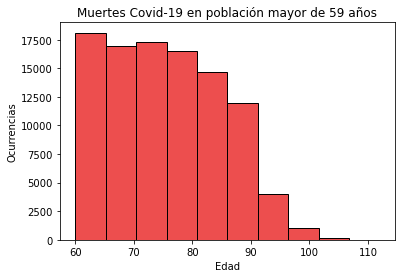

In [31]:
# histograma de muertes por mes

sns.histplot(data=mayores_59, x="edad", bins=10, color="#E71313")
plt.xlabel("Edad")
plt.ylabel("Ocurrencias")
plt.title("Muertes Covid-19 en población mayor de 59 años")

In [33]:
# Separamos dataframe por sexo

mayores_59fem = mayores_59[mayores_59["sexo"] == "F"]
mayores_59masc = mayores_59[mayores_59["sexo"] == "M"]

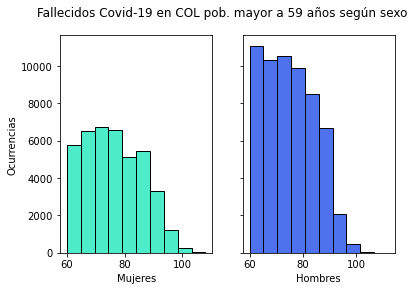

In [34]:
# Histograma de muertes por mes-sexo

fig, axes = plt.subplots(1,2, sharey=True)
sns.histplot(ax=axes[0], data=mayores_59fem, x="edad", bins=10, color="#13E7B7")
sns.histplot(ax=axes[1], data=mayores_59masc, x="edad", bins=10, color="#1343E7")

axes[0].set(xlabel="Mujeres", ylabel="Ocurrencias")
axes[1].set(xlabel="Hombres",)
fig.suptitle("Fallecidos Covid-19 en COL pob. mayor a 59 años según sexo")
plt.show()

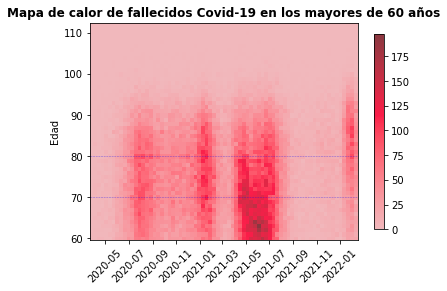

In [47]:
# Ploteamos mapa de saturación de color

sns.histplot(x="fecha_muerte", y="edad", data=mayores_59, discrete=(False, True),\
             color="#D10A38", thresh=None, cbar=True, cbar_kws=dict(shrink=.9))
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Edad")
plt.title("Mapa de calor de fallecidos Covid-19 en los mayores de 60 años", fontweight="bold")
plt.axhline(y=70, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.axhline(y=80, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.show()

#### Consulta 1: data de menores de 60 años

In [48]:
# Repetimos procesos
query2 = f"""SELECT fecha_reporte_web, departamento_nom, \
    ciudad_municipio_nom, edad, sexo, ubicacion, estado, recuperado, fecha_inicio_sintomas, fecha_muerte  WHERE edad < 60 AND \
        recuperado =  'Fallecido' OR  recuperado = 'fallecido' AND edad < 60 LIMIT 6050000"""

results2 = client.get("gt2j-8ykr", query=query2)

In [49]:
menores_60 = pd.DataFrame.from_records(results2)

In [50]:
# Arreglamos formatos y datos mal digitados 
menores_60[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]] = \
    menores_60[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]].apply(pd.to_datetime)
menores_60["edad"] = menores_60["edad"].astype("int64")

menores_60["recuperado"].replace({"fallecido":"Fallecido"}, inplace=True)
menores_60["departamento_nom"].replace\
({"BARRANQUILLA":"ATLANTICO","CARTAGENA":"BOLIVAR","STA MARTA D.E.":"MAGDALENA",\
  "Caldas":"CALDAS","Tolima":"TOLIMA"}, inplace=True)
menores_60["sexo"].replace({"f":"F","m":"M"},inplace=True)

In [51]:
# Creamos columna omitiendo día de fecha de muerte y aplicamos formato

menores_60["año_mes"] = menores_60["fecha_muerte"].dt.strftime("%Y-%m")

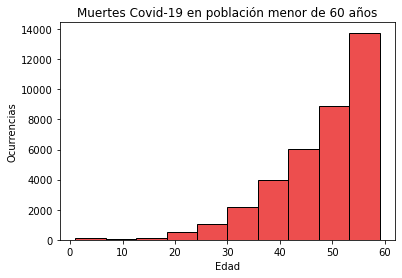

In [54]:
# histograma de muertes por mes

sns.histplot(data=menores_60, x="edad", bins=10, color="#E71313")
plt.xlabel("Edad")
plt.ylabel("Ocurrencias")
plt.title("Muertes Covid-19 en población menor de 60 años")
plt.show()

In [58]:
# Separamos dataframe por sexo

menores_60fem = mayores_59[mayores_59["sexo"] == "F"]
menores_60masc = mayores_59[mayores_59["sexo"] == "M"]

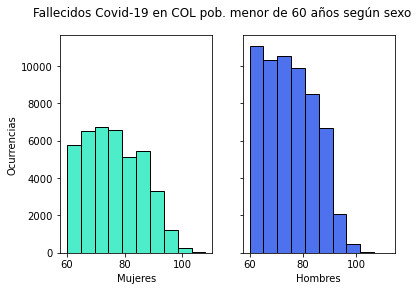

In [59]:
# Histograma de muertes por mes-sexo

fig, axes = plt.subplots(1,2, sharey=True)
sns.histplot(ax=axes[0], data=menores_60fem, x="edad", bins=10, color="#13E7B7")
sns.histplot(ax=axes[1], data=menores_60masc, x="edad", bins=10, color="#1343E7")

axes[0].set(xlabel="Mujeres", ylabel="Ocurrencias")
axes[1].set(xlabel="Hombres",)
fig.suptitle("Fallecidos Covid-19 en COL pob. menor de 60 años según sexo")
plt.show()

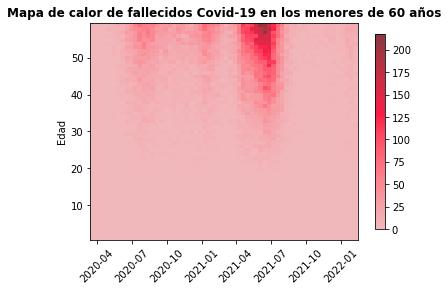

In [60]:
# Ploteamos mapa de saturación de color

sns.histplot(x="fecha_muerte", y="edad", data=menores_60, discrete=(False, True),\
             color="#D10A38", thresh=None, cbar=True, cbar_kws=dict(shrink=.9))
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Edad")
plt.title("Mapa de calor de fallecidos Covid-19 en los menores de 60 años", fontweight="bold")
plt.show()

### Unimos Dataframes

In [61]:
frames = [mayores_59, menores_60]

In [62]:
# concatenamos 
all_ages = pd.concat(frames)

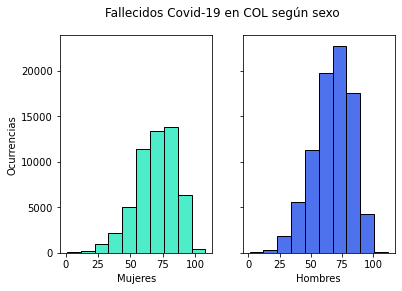

In [76]:
# Separamos dataframe por sexo

muertes_fem = all_ages[all_ages["sexo"] == "F"]
muertes_masc = all_ages[all_ages["sexo"] == "M"]

# Histograma de muertes por mes-sexo
fig, axes = plt.subplots(1,2, sharey=True)
sns.histplot(ax=axes[0], data=muertes_fem, x="edad", bins=10, color="#13E7B7")
sns.histplot(ax=axes[1], data=muertes_masc, x="edad", bins=10, color="#1343E7")

axes[0].set(xlabel="Mujeres", ylabel="Ocurrencias")
axes[1].set(xlabel="Hombres",)
fig.suptitle("Fallecidos Covid-19 en COL según sexo")
plt.show()

In [82]:
# Hacemos un simple conteo de muertes por sexo y mes

comparacion = all_ages.pivot_table(index=["año_mes"], columns="sexo",values="edad", aggfunc="count").reset_index()

sexo  año_mes     F     M
0     2020-03    12    18
1     2020-04   129   202
2     2020-05   348   525
3     2020-06  1167  1952
4     2020-07  2698  4987


sexo,año_mes,F,M,dif_%
0,2020-03,12,18,50.00
1,2020-04,129,202,56.59
2,2020-05,348,525,50.86
3,2020-06,1167,1952,67.27
4,2020-07,2698,4987,84.84
5,2020-08,3177,5794,82.37
6,2020-09,2069,3677,77.72
7,2020-10,1928,3416,77.18
8,2020-11,1958,3456,76.51
9,2020-12,2511,4282,70.53


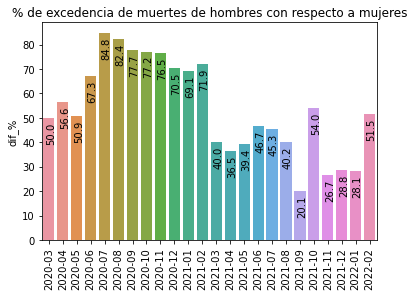

In [108]:
# Creamos nueva columna que represente el exceso de muertes de
# ...los hombres con respecto a las mujeres (diferencia de porcentajes)

comparacion["dif_%"] = round((comparacion["M"]*100/comparacion["F"]-100),2)

plco = sns.barplot(x="año_mes",y="dif_%", data=comparacion)
plt.xticks(rotation=90)
plt.title("% de excedencia de muertes de hombres con respecto a mujeres")
plt.xlabel("")

for bar in plco.patches:
    plco.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                   bar.get_height()), ha='center', va='center', rotation=90,
    size=10, xytext=(2, -15), #inicialmente en (0,5)
    textcoords='offset points')
    
comparacion.head(10)

Es evidente cómo los hombres han sufrido un mayor número de muertes Covid-19 a lo largo de toda la pandemia, las causas son muy variables y no entraremos en detalle. 
Por otro lado, hay cifras curiosas con respecto al porcentaje de excedencia de muertes en hombres, pues a partir de marzo de 2021, un mes después de iniciada la vacunación, el valor deja de estar por arriba del 70% para pasar a menos de 40%.

In [63]:
# Agrupamos data por mpromedio de edad de fallecidos y reseteamos indices 

all_muertes = all_ages.groupby("fecha_muerte")["edad"].mean().reset_index()
# Para suavizar los datos, agregamos un promedio móvil de 7 días

all_muertes["media_movil"] = all_muertes["edad"].rolling(window=7).mean()

# No queremos tener en cuenta las muertes ocurridas antes de mayo del 2020
# ...debido a que habían ocurrido pocos casos y alteraría la curva

all_muertes["media_movil"] = all_muertes["media_movil"].\
mask(all_muertes["fecha_muerte"] < "2020-05-01", np.nan).astype(float)

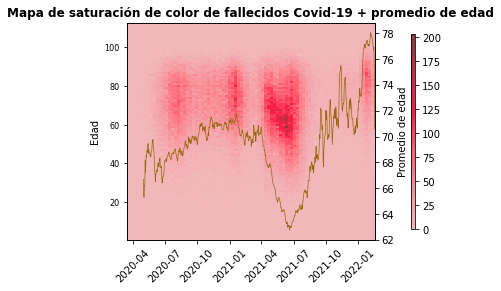

In [75]:
# Plotemamos gráfico combinado con la función ax.twinx()

ax = sns.histplot(x="fecha_muerte", y="edad", data=all_ages, discrete=(False, True), color="#D10A38", thresh=None, cbar=True,\
                  cbar_kws=dict(shrink=.9, pad=0.11, aspect=50))
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.xlabel("")
plt.ylabel("Edad")
plt.title("Mapa de saturación de color de fallecidos Covid-19 + promedio de edad", fontweight="bold")

# Este es el código para graficar la curva de la edad media de fallecidos a lo largo del tiempo
ax2 = ax.twinx()
sns.lineplot(x="fecha_muerte",y="media_movil", data=all_muertes, ax=ax2, color="#99680E", linewidth=0.7)
plt.ylabel("Promedio de edad")
plt.show()

### ¿Qué nos muestra el gráfico?

* En la cuarta oleada, hubo mayor cantidad de muertes en los adultos mayores (eje Y derecho) de 75 años, mientras que en las oleadas anteriores, el promedio de edad estuvo entre los 62 y 70.

* La caída que hubo en el tercer pico se debe a que hubo mayor protección en los mayores de 70, pues fue el primer grupo poblacional en recibir las vacunas contra el Covid-19, no debemos olvidar, que la vacunación inició a un ritmo muy lento.

* Claramente se nota cómo el tercer pico fue el que más muertes trajo entre los 60 y 70 años, mientras que en el actual, hay mayor proporción en los mayores de 80.

* También se nota lo prolongado que fue el pico de Mu (tercero); éste último, aunque no ha terminado del todo (al 13 de febrero de 2022), va a ser el más corto.

Algunos se preguntarán, ¿entonces por qué murieron tantos adultos mayores como en el tercer pico?

Varios factores:

* Baja cobertura en las dosis de refuerzo
* La Efectividad de las vacunas baja drásticamente a mayor edad y a medida que pasa el tiempo
* Comorbilidades presentes en estos grupos etarios
* Población que siempre va a estar en mayor riesgo
* No es lo mismo la efectividad de dos dosis a los 6 meses en una persona joven y sana que en un adulto mayor, si hay algo que rescatar, es que el pico fue de menor duración, o sea, menos muertes tomando el acumulado. Pasamos de +23.000 en el tercer pico a +5.000 en el actual.